In [1]:
# Necessary imports
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.preprocessing import minmax_scale
%pylab inline

/Users/lorenchen/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_json('jeop_data.json')

In [3]:
df.head()

,DD,coryat,date,dj_score,game_id,name,player_id,right,score,season,wrong
0,0,8400,2017-07-28,8400,7585,Dan Viafore,11599,13,7199,33,1
1,3,18600,2009-07-24,18000,5745,Emily Bruemmer,6274,21,11000,25,2
2,1,19400,2008-07-25,19800,5515,Emily Thorsley,5162,20,29800,24,2
3,2,16400,2007-07-13,21800,5275,Ben Taylor,3966,20,25599,23,4
4,0,8400,2006-07-28,8400,5055,Brad Jeffcoat,2393,15,16400,22,3


In [4]:
cols = ['season','game_id','date','name','player_id','score', 'dj_score', 'coryat','right','wrong','DD']

In [5]:
df = df[cols]

In [6]:
df[df.name=='Watson']

,season,game_id,date,name,player_id,score,dj_score,coryat,right,wrong,DD
964,27,6087,2011-02-15,Watson,7208,35734,36681,31600,38,5,3


In [7]:
df.drop(df[df.game_id==6087].index, inplace=True)

In [8]:
df['buzzes']=df.right + df.wrong - df.DD
df['q_perc'] = df.right / (df.right + df.wrong)
df = df.sort_values(by=['date','score'], ascending=[True, False])
df['total_buzzes'] = df['buzzes'].groupby(df['game_id']).transform('sum')
df['buzz_perc'] = df.buzzes / df.total_buzzes

In [9]:
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df['weekday'] = df.date.dt.weekday

In [10]:
df['game_rank'] = df.groupby('game_id')['score'].rank(method='min',ascending=False)
df['game_number'] = df.groupby('player_id')['date'].rank()
df['game_winner'] = (df.game_rank==1)*1

In [11]:
df.head()

,season,game_id,date,name,player_id,score,dj_score,coryat,right,wrong,DD,buzzes,q_perc,total_buzzes,buzz_perc,weekday,game_rank,game_number,game_winner
2057,20,4366,2003-09-08,Sam Ott,4101,12401,7000,8600,24,8,2,30,0.750000,57,0.526316,0,1.0,1.0,1
2056,20,4366,2003-09-08,Nick Thurkettle,4100,7100,6200,7000,11,6,1,16,0.647059,57,0.280702,0,2.0,1.0,0
1993,20,4366,2003-09-08,Sharon Fenick,4099,5199,2600,2600,9,2,0,11,0.818182,57,0.192982,0,3.0,1.0,0
2059,20,4367,2003-09-09,Sam Ott,4101,18001,14500,13600,21,4,1,24,0.840000,56,0.428571,1,1.0,2.0,1
1994,20,4367,2003-09-09,Matt McWha,6693,11500,9000,10400,13,6,2,17,0.684211,56,0.303571,1,2.0,1.0,0


In [12]:
df.sort_values(by='buzzes', ascending = False).filter(['date', 'name', 'buzzes', 'score']).head(25)

,date,name,buzzes,score
107,2004-07-20,Ken Jennings,46,29200
4392,2004-10-08,Ken Jennings,45,30000
48,2004-07-23,Ken Jennings,44,75000
7701,2004-07-12,Ken Jennings,44,52000
4107,2004-09-09,Ken Jennings,44,21800
6869,2004-06-10,Ken Jennings,43,50000
109,2004-07-21,Ken Jennings,43,30000
4105,2004-09-08,Ken Jennings,43,27200
4292,2004-09-17,Ken Jennings,42,50000
7702,2004-07-13,Ken Jennings,42,32000


In [13]:
df[['perc_rank','buzz_rank']] = df[['q_perc', 'buzz_perc']].rank(pct=True)
cat_names = ['Worst', 'Worse', 'Better', 'Best']
cuts = [0, 0.25, 0.5, 0.75, 1]
df['perc_cat'] = pd.cut(df['perc_rank'], cuts, labels=cat_names)
df['buzz_cat'] = pd.cut(df['buzz_rank'], cuts, labels=cat_names)

In [14]:
binned_df = df.groupby(['perc_cat', 'buzz_cat']).agg({'score': 'mean',
                                                   'name': 'count'}).reset_index()
buz_q = binned_df.pivot('perc_cat', 'buzz_cat', 'score')

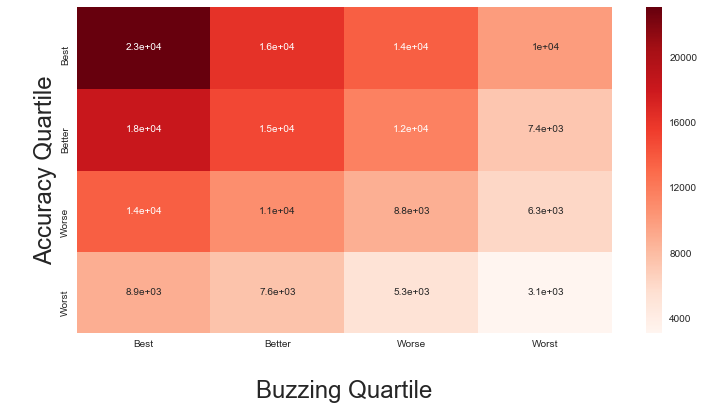

In [15]:
plt.figure(figsize=(12,6))
sns.heatmap(buz_q, annot=True, cmap='Reds')
plt.xlabel("\nBuzzing Quartile", fontsize=24)
plt.ylabel("\nAccuracy Quartile", fontsize=24);

In [16]:
df[['buzz_2', 'q_2', 'DD_2']] = df[['buzz_perc', 'q_perc', 'DD']]**2

In [17]:
df[['cum_buzz', 'cum_total','cum_right','cum_wrong', 'cum_DD']] =df.groupby('name')[['buzzes', 'total_buzzes', 'right', 'wrong', 'DD']].cumsum()

In [18]:
df['cum_buzz_p'] = df.cum_buzz / df.cum_total
df['cum_q'] = df.cum_right / (df.cum_right + df.cum_wrong)
df['avg_DD'] = df.cum_DD / df.game_number

In [19]:
df.head()

,season,game_id,date,name,player_id,score,dj_score,coryat,right,wrong,...,q_2,DD_2,cum_buzz,cum_total,cum_right,cum_wrong,cum_DD,cum_buzz_p,cum_q,avg_DD
2057,20,4366,2003-09-08,Sam Ott,4101,12401,7000,8600,24,8,...,0.562500,4,30,57,24,8,2,0.526316,0.750000,2.0
2056,20,4366,2003-09-08,Nick Thurkettle,4100,7100,6200,7000,11,6,...,0.418685,1,16,57,11,6,1,0.280702,0.647059,1.0
1993,20,4366,2003-09-08,Sharon Fenick,4099,5199,2600,2600,9,2,...,0.669421,0,11,57,9,2,0,0.192982,0.818182,0.0
2059,20,4367,2003-09-09,Sam Ott,4101,18001,14500,13600,21,4,...,0.705600,1,54,113,45,12,3,0.477876,0.789474,1.5
1994,20,4367,2003-09-09,Matt McWha,6693,11500,9000,10400,13,6,...,0.468144,4,17,56,13,6,2,0.303571,0.684211,2.0


### Create a new dataframe with only relevant columns, and then normalize the range of the regressors to lie between 0 and 1.

In [20]:
normed_df = df.loc[:,['name', 'dj_score', 'game_winner', 'buzz_perc', 'q_perc', 'DD']]

In [21]:
normed_df['norm_buzz'] = minmax_scale(normed_df['buzz_perc'], axis=0)
normed_df['norm_q'] = minmax_scale(normed_df['q_perc'], axis=0)
normed_df['norm_DD'] = minmax_scale(normed_df['DD'], axis=0)

/Users/lorenchen/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, _DataConversionWarning)


In [22]:
normed_df.head()

,name,dj_score,game_winner,buzz_perc,q_perc,DD,norm_buzz,norm_q,norm_DD
2057,Sam Ott,7000,1,0.526316,0.750000,2,0.600808,0.666667,0.666667
2056,Nick Thurkettle,6200,0,0.280702,0.647059,1,0.299622,0.529412,0.333333
1993,Sharon Fenick,2600,0,0.192982,0.818182,0,0.192055,0.757576,0.000000
2059,Sam Ott,14500,1,0.428571,0.840000,1,0.480948,0.786667,0.333333
1994,Matt McWha,9000,0,0.303571,0.684211,2,0.327666,0.578947,0.666667


In [23]:
cols = 'norm_buzz norm_DD norm_q dj_score'.split()
train_set, test_set = train_test_split(normed_df[cols], test_size=0.3)

In [24]:
def calc_r2(data, x, y, fit):
    score_mean = data[y].mean()
    TSS = sum((data[y] - score_mean)**2)
    pred = fit.predict(data[x])
    resid = data[y] - pred
    SSR = sum(resid**2)
    R2 = 1 - SSR/TSS
    return R2

In [25]:
cols = 'norm_buzz norm_DD norm_q dj_score'.split()
train_set, test_set = train_test_split(normed_df[cols], test_size=0.3, random_state = 42)
lm2 = smf.ols('dj_score ~ norm_buzz + norm_DD + norm_buzz:norm_q + norm_q:norm_DD', data=train_set)
fit2 = lm2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               dj_score   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     4355.
Date:                Mon, 09 Oct 2017   Prob (F-statistic):               0.00
Time:                        13:34:26   Log-Likelihood:                -51543.
No. Observations:                5430   AIC:                         1.031e+05
Df Residuals:                    5425   BIC:                         1.031e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          929.0281    138.281      6.718      0.000     657.942    1200.114
norm_buzz        -2.927e+04   1403.501    -20.852      0.000    -3.2e+04   -2.65e+04
norm_DD          -9918.1058   1141.221     -8.691      0.000   -1.22e+04   -7680.854
norm_buzz:norm_q  6.682e+04   1603.815     41.666      0.000    6.37e+04       7e+04
norm_q:norm_DD    1.721e+04   1403.357     12.267      0.000    1.45e+04       2e+04
==============================================================================
Omnibus:                      515.262   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1500.962
Skew:                           0.509   Prob(JB):                         0.00
Kurtosis:                       5.366   Cond. No.                         71.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
print('Train R^2: ' +str(calc_r2(train_set, ['norm_buzz', 'norm_q','norm_DD'], 'dj_score', fit2)))
print('Test R^2: ' +str(calc_r2(test_set, ['norm_buzz', 'norm_q','norm_DD'], 'dj_score', fit2)))

Train R^2: 0.76253093111323
Test R^2: 0.7597844760587399


In [27]:
normed_df['predicted_dj']= fit2.predict(normed_df)

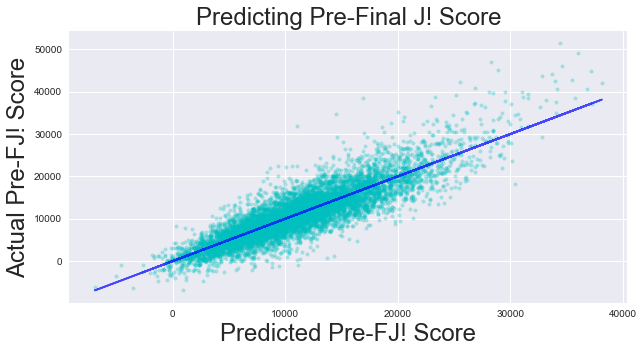

In [28]:
plt.figure(figsize=(10,5))
plt.scatter('predicted_dj', 'dj_score', data = normed_df, alpha = 0.3, color = 'c', marker = ".", label = '')

plt.plot('predicted_dj', 'predicted_dj', data=normed_df, color = 'b', alpha = 0.7)
plt.xlabel('Predicted Pre-FJ! Score', fontsize = 24)
plt.ylabel("Actual Pre-FJ! Score", fontsize=24)
plt.title('Predicting Pre-Final J! Score', fontsize=24);

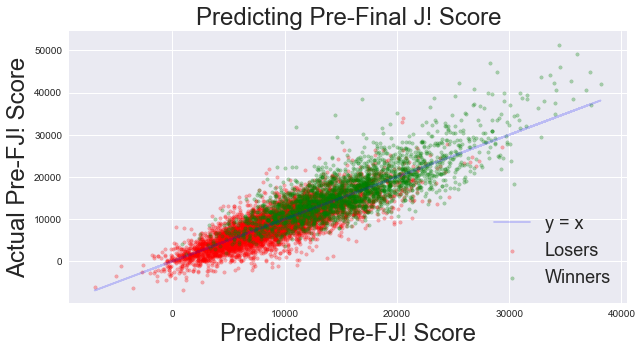

In [29]:
plt.figure(figsize=(10,5))
plt.scatter('predicted_dj', 'dj_score', data = normed_df[normed_df.game_winner == 0], alpha = 0.3, color = 'r', marker = ".", label = 'Losers')
plt.scatter('predicted_dj', 'dj_score', data = normed_df[normed_df.game_winner == 1], alpha = 0.3, color = 'g', marker = '.', label = 'Winners')
# plt.scatter('predicted_dj', 'dj_score', data = normed_df[normed_df.name == 'Loren Lee Chen'], alpha = 1, color = 'b', s = 100, marker = 'o', label = 'Me')

plt.plot('predicted_dj', 'predicted_dj', data=normed_df, label='y = x',color = 'b', alpha = 0.2)
plt.xlabel('Predicted Pre-FJ! Score', fontsize = 24)
plt.ylabel("Actual Pre-FJ! Score", fontsize=24)
plt.title('Predicting Pre-Final J! Score', fontsize=24)
plt.legend(loc=4, fontsize = 18);

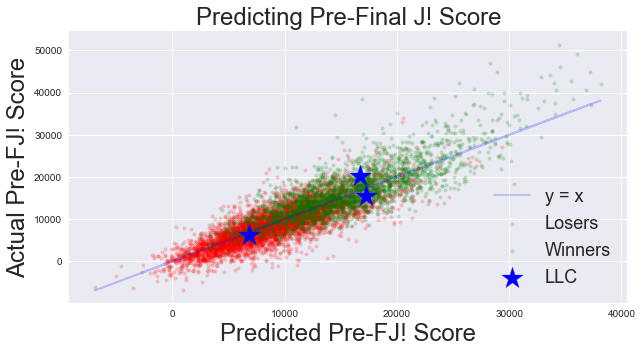

In [30]:
plt.figure(figsize=(10,5))
plt.scatter('predicted_dj', 'dj_score', data = normed_df[normed_df.game_winner == 0], alpha = 0.2, color = 'r', marker = ".", label = 'Losers')
plt.scatter('predicted_dj', 'dj_score', data = normed_df[normed_df.game_winner == 1], alpha = 0.2, color = 'g', marker = '.', label = 'Winners')

plt.plot('predicted_dj', 'predicted_dj', data=normed_df, color = 'b', label='y = x', alpha=0.2)

plt.scatter('predicted_dj', 'dj_score', data = normed_df[normed_df.name == 'Loren Lee Chen'], color = 'b', s = 500, marker = '*', label = 'LLC')

plt.xlabel('Predicted Pre-FJ! Score', fontsize = 24)
plt.ylabel("Actual Pre-FJ! Score", fontsize=24)
plt.title('Predicting Pre-Final J! Score', fontsize=24)
plt.legend(loc=4, fontsize = 18);

In [31]:
normed_df.sort_values(by='predicted_dj', inplace=True)

In [32]:
predk = (normed_df.predicted_dj // 4000 * 4000).astype(int)

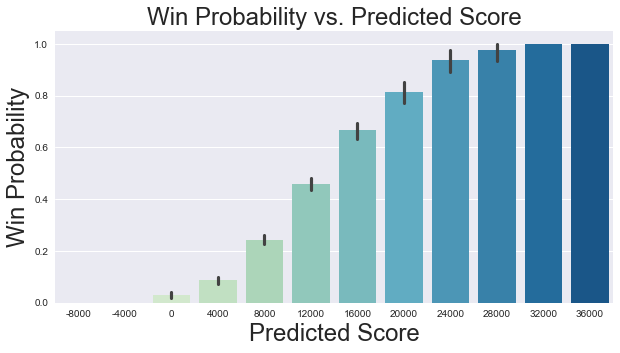

In [33]:
plt.figure(figsize=(10,5))
sns.barplot(predk, normed_df.game_winner, palette = 'GnBu')
plt.title("Win Probability vs. Predicted Score", fontsize=24)
plt.xlabel("Predicted Score", fontsize=24)
plt.ylabel("Win Probability", fontsize=24);

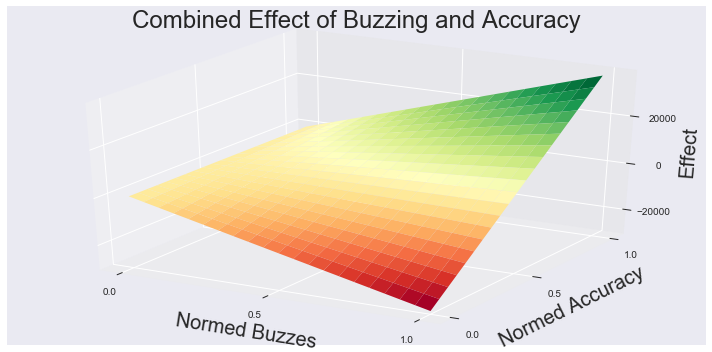

In [34]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111, projection='3d')
x = arange(0,1.05,0.05)
y = arange(0,1.05, 0.05)
xx, yy = np.meshgrid(x, y)
z = -29270*xx + 66820*xx*yy

ax.plot_surface(xx, yy, z, cmap='RdYlGn')
ax.set_xticks([-0,0.5,1])
ax.set_yticks([-0, 0.5, 1])
ax.set_zticks([-20000,0,20000])
ax.set_xlabel('\nNormed Buzzes', fontsize=20)
ax.set_ylabel('\nNormed Accuracy', fontsize=20)
ax.set_zlabel('\nEffect', fontsize=20)
plt.tight_layout()
ax.set_title('Combined Effect of Buzzing and Accuracy', fontsize=24);

# Code for creating animated rotation:
# for ii in arange(0,360,45):
#     ax.view_init(elev=10., azim=ii)
#     savefig("img/movie"+str(ii)+".png");

In [35]:
def get_z(x, y):
    z = -29270*x + 66820*x*y
    return z

In [36]:
proportion = 29270/66820
print(proportion)
normed_df[normed_df.norm_q > proportion].sort_values(by='norm_q').head(1)

0.4380425022448369


,name,dj_score,game_winner,buzz_perc,q_perc,DD,norm_buzz,norm_q,norm_DD,predicted_dj
3233,Garrett Levenbrook,2800,0,0.369565,0.578947,2,0.408592,0.438596,0.666667,-631.684079


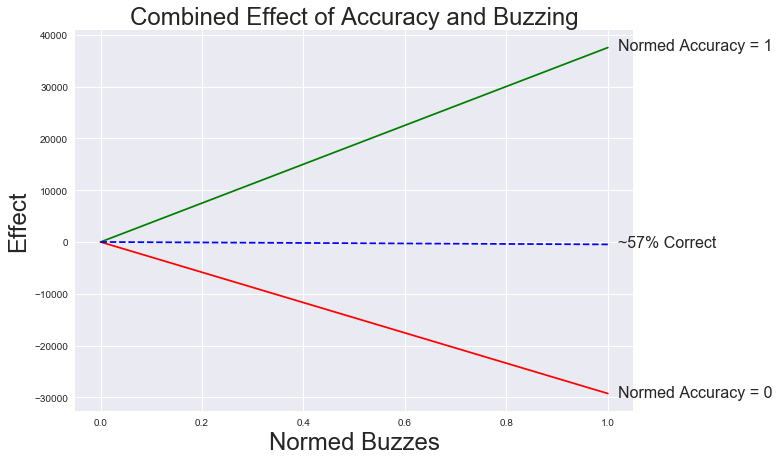

In [37]:
x = arange(0,1.05,0.05)

fig = plt.figure(figsize=(10,7))
# plt.title('Buzzing Effect for Different Accuracy', fontsize=24)
sns.plt.plot(x, get_z(x, 1), color = 'g')
sns.plt.plot(x, get_z(x, 0), color = 'r')
sns.plt.plot(x, get_z(x, 0.431), '--', color = 'b')
plt.annotate("Normed Accuracy = 1", (1.02, 37000), fontsize=16)
plt.annotate("Normed Accuracy = 0", (1.02, -30000), fontsize=16)
plt.annotate("~57% Correct", (1.02, -1000), fontsize=16)
plt.xlabel("Normed Buzzes", fontsize=24)
plt.ylabel("Effect", fontsize=24)
plt.title('Combined Effect of Accuracy and Buzzing', fontsize=24);


In [38]:
normed_df[normed_df.name=='Loren Lee Chen']

,name,dj_score,game_winner,buzz_perc,q_perc,DD,norm_buzz,norm_q,norm_DD,predicted_dj
4408,Loren Lee Chen,6200,0,0.296296,0.764706,1,0.318745,0.686275,0.333333,6850.452600
4240,Loren Lee Chen,20200,1,0.431373,0.875000,2,0.484383,0.833333,0.666667,16678.899030
4308,Loren Lee Chen,15400,1,0.522727,0.840000,2,0.596408,0.786667,0.666667,17243.367927


In [40]:
normed_df[normed_df.predicted_dj>30000].name.count()

31